## Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day. For more information regarding the dataset, click [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [15]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


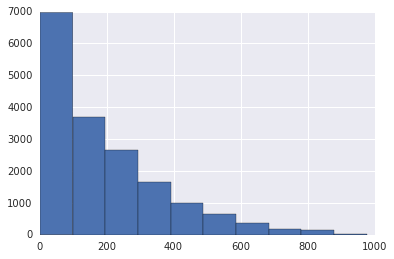

In [16]:
plt.hist(bike_rentals['cnt'])
plt.show()

## Data Analysis and Feature Engineering

In [17]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

Using a histogram, we've quickly plotted the distribution of the 'cnt' column. This is the total number of bike rentals for a particular hour of a day. We can see that this is a right skewed distribution. The 50% percentile, or the median is 142.

In [18]:
#Correlation between the feature columns and the target column
import seaborn as sns
corrmat  = bike_rentals.corr()['cnt'].sort_values(ascending = False)
corrmat

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

Let's ignore the casual and registered columns because 'cnt' is derived from them. Since we are trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that we already know casual or registered, because those numbers are added together to get cnt.

The 'dteday' column is just the date, and can't be used in this machine learning exercise.

In [19]:
features = bike_rentals.columns.drop(['cnt', 'casual', 'dteday', 'registered'])

The 'hr' column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [11]:
def assign_label(hour):
    #Night
    if hour >=0 and hour < 6:
        return 4
    #Morning
    elif hour >=6 and hour < 12:
        return 1
    #Afternoon
    elif hour >= 12 and hour < 18:
        return 2
    #Evening
    elif hour >= 18 and hour <=24:
        return 3
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

## Applying Machine Learning

Let's randomly sample 80% of the data and assign it to the training set. Then we can use the remaining 20% as the testing set.

In [12]:
#Train & Test Split
train = bike_rentals.sample(frac = 0.8, random_state = 1)
test = bike_rentals.drop(train.index, axis=0)
train.shape[0] + test.shape[0] == bike_rentals.shape[0]

True

## Linear Regression

We will use MSE for the evauation of the machine learning algorithm's. MSE works well since the target column 'cnt' is continuous.

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

model.fit(train[features], train['cnt'])
predicted = model.predict(test[features])

mse = mean_squared_error(predicted, test['cnt'])
mse

19580.734550455003

In [21]:
predicted = model.predict(train[features])

mse = mean_squared_error(predicted, train['cnt'])
mse

20239.45597121294

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error. The linear regression model is probably not the best for this dataset. Let's start by using a single tree model.

## Decision Tree

In [22]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_samples_leaf=5)
model.fit(train[features], train['cnt'])
predicted = model.predict(test[features])
mse = mean_squared_error(predicted, test['cnt'])
mse

2730.80696655105

As we can see, the decision tree model reduced our error signficantly. By taking the nonlinear features into account, the decision tree regressor appears to have much higher accuracy than linear regression.

Let's use the Random Forest algorithm to reduce our error since it reduces  the overfitting issue.

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=250, min_samples_leaf=2)
model.fit(train[features], train['cnt'])
predicted = model.predict(test[features])
mse = mean_squared_error(predicted, test['cnt'])
mse

1840.4772306890686

The Random Forest model has reduced our error further. We have specified the hyperparameter values 'min_samples_leaf' and 'n_estimators', which can be optimized by using a for loop.

In [29]:
mse_leaf=[]
for i in range(1, 10):
    model = RandomForestRegressor(min_samples_leaf=i, n_estimators=250)
    model.fit(train[features], train['cnt'])
    predicted = model.predict(test[features])

    mse = mean_squared_error(test['cnt'], predicted)
    mse_leaf.append(mse)
mse_leaf

[1823.4522851369388,
 1833.6084329492671,
 1927.1207965832944,
 1973.0789837150246,
 2018.8543807271449,
 2090.4021170509136,
 2133.901890421691,
 2206.2752128511656,
 2254.273468880916]

In [30]:
n_trees = [250, 500, 750]
mse_trees=[]
for i in n_trees:
    model = RandomForestRegressor(min_samples_leaf=2, n_estimators=i)
    model.fit(train[features], train['cnt'])
    predicted = model.predict(test[features])

    mse = mean_squared_error(test['cnt'], predicted)
    mse_trees.append(mse)
mse_trees

[1843.5043373444066, 1847.005338565824, 1837.5222080497697]

By tweaking the hyperparameter values, we were able to acheive better results. The random forest regressor is a powerful tool. However, using a large amount of trees in conjunction with a for loop takes a very long time to process.

By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.